# Detection Experiments

In this notebook we'll walk through several different CNN architectures to solve a problem of detecting a MNIST digit on an image with several MNIST diigits in random places. 

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
!nvidia-smi

Tue Jan 16 12:19:01 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.26                 Driver Version: 375.26                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:02:00.0     Off |                  N/A |
| 18%   48C    P8    15W / 200W |      0MiB /  8113MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:03:00.0     Off |                  N/A |
| 24%   49C    P8    15W / 200W |      0MiB /  8112MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [3]:
# import tensorflow as tf

In [4]:
# sess = tf.Session()

In [5]:
import os
import sys
import blosc
import seaborn

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm as tqdm

sys.path.append("..")
sys.path.append("..//..")
from dataset.dataset.opensets import MNIST
from dataset.models.tf.resnet import ResNet, ResNet18

# from dataset.models.tf.mobilenet import MobileNet

from find_bounding_boxes import DetectionBatch
from task_03.my_batch import MnistBatch
from dataset import DatasetIndex, Dataset
from dataset import F, V, B, Pipeline
from task_03.my_batch import draw_stats, draw_digit
from end_to_end import DetectionResNet2, DetectionResNet, SimpleDetection

In [6]:
mnistset = MNIST(batch_class=DetectionBatch)
mnistset.cv_split([0.9, 0.1])

ExtractingExtractingExtracting /tmp/train-labels-idx1-ubyte.gz 
/tmp/train-images-idx3-ubyte.gz Extracting/tmp/t10k-labels-idx1-ubyte.gz

 /tmp/t10k-images-idx3-ubyte.gz


In [7]:
NUM_ITERS = 2400

In [8]:
BATCH_SIZE = 100
NUM_OTHERS = 3

In [9]:
NEW_SIZE = 80

In [10]:
placeholders_config = {'images': {'shape': (NEW_SIZE, NEW_SIZE, 1),
                                  'name': 'reshaped_images'},
                       'labels': {'classes' : 10,
                                  'transform': 'ohe',
                                  'name': 'targets'},
                       'coordinates': {'shape': (4)},
                       'other_coordinates': {'shape': (NUM_OTHERS, 4)},
                       'other_labels': {'shape': (NUM_OTHERS)}}
                       
config={'inputs': placeholders_config,
        'input_block/inputs': 'images',
        'loss': None}

In [11]:
saved_fetches=[
               V('loss_history'),
               V('acc_history'),
               V('ce_loss_history'),
               V('huber_loss_history')]

saved_feed_dict={'images': B('images'),
                 'labels': B('labels'),
                 'coordinates': B('coordinates'),
                 'other_coordinates': B('other_coordinates'),
                 'other_labels':  B('other_labels')}

In [12]:
template_ppl = (Pipeline()
               .enlarge_data(num_others=NUM_OTHERS, new_size=NEW_SIZE)
               .init_variable('acc_history', init_on_each_run=list)
               .init_variable('loss_history', init_on_each_run=list)
               .init_variable('ce_loss_history', init_on_each_run=list)
               .init_variable('huber_loss_history', init_on_each_run=list))

In [13]:
train_ppls = []
test_ppls = []

In [14]:
models = [SimpleDetection, DetectionResNet, DetectionResNet2]
model_names = ['SimpleDetection', 'DetectionResNet', 'DetectionResNet2']

In [15]:
for index, name in enumerate(model_names):
    fetches_list=['loss',
                   name + '/accuracy',
                   name + '/ce_loss:0',
                   name + '/huber:0']

    ppl = ((template_ppl << mnistset.train)
                     .init_model('dynamic', models[index], name, config=config)
                     .train_model(name, fetches=fetches_list, feed_dict=saved_feed_dict,
                                  save_to=saved_fetches, mode='a'))
    ppl_test = ((template_ppl << mnistset.test)
                     .import_model(name, ppl)
                     .predict_model(name, fetches=fetches_list, feed_dict=saved_feed_dict,
                                  save_to=saved_fetches, mode='a'))

    
    for i in tqdm(range(NUM_ITERS)):
        ppl.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
        ppl_test.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
    
    train_ppls.append(ppl)
    test_ppls.append(ppl_test)

  0%|          | 0/2400 [00:00<?, ?it/s]

outputs.shape  (?, 4)


  0%|          | 0/2400 [00:00<?, ?it/s]

outputs.shape  (?, 14)
other_labels[:, i]  Tensor("DetectionResNet/strided_slice_8:0", shape=(?,), dtype=float32)
other_labels[:, i]  Tensor("DetectionResNet/strided_slice_10:0", shape=(?,), dtype=float32)
other_labels[:, i]  Tensor("DetectionResNet/strided_slice_12:0", shape=(?,), dtype=float32)


  0%|          | 0/2400 [00:00<?, ?it/s]

outputs.shape  (?, 4)
other_labels[:, i]  Tensor("DetectionResNet2/strided_slice_12:0", shape=(?,), dtype=float32)
current_accy  [1]
other_labels[:, i]  Tensor("DetectionResNet2/strided_slice_14:0", shape=(?,), dtype=float32)
current_accy  [1]
other_labels[:, i]  Tensor("DetectionResNet2/strided_slice_16:0", shape=(?,), dtype=float32)
current_accy  [1]


100%|██████████| 2400/2400 [10:53<00:00,  3.98it/s]


In [16]:
# ppl = ((template_ppl << mnistset.train)
#                      .init_model('dynamic', DetectionResNet, 'DetectionResNet', config=config)
#                      .train_model('DetectionResNet', fetches=fetches_list, feed_dict=saved_feed_dict,
#                                   save_to=saved_fetches, mode='a'))

In [17]:
# ppl_test = ((template_ppl << mnistset.test)
#                      .import_model('DetectionResNet', ppl)
#                      .predict_model('DetectionResNet', fetches=fetches_list, feed_dict=saved_feed_dict,
#                                   save_to=saved_fetches, mode='a'))

In [18]:
# for i in tqdm(range(NUM_ITERS)):
#     ppl.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
#     ppl_test.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)

In [19]:
train_ppls

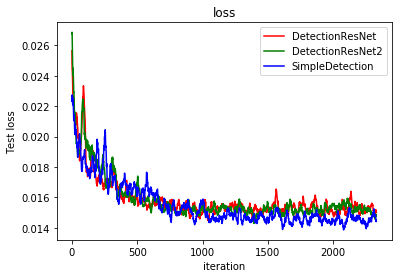

In [56]:
window = 50
draw_stats([test_ppls[1].get_variable('huber_loss_history')[window:], \
            test_ppls[2].get_variable('huber_loss_history')[window:], test_ppls[0].get_variable('huber_loss_history')[window:]], 
            ['DetectionResNet', 'DetectionResNet2', 'SimpleDetection'], 'loss', 'Test loss')

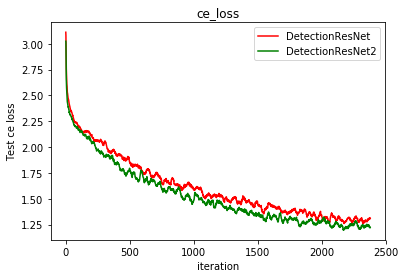

In [26]:
draw_stats([train_ppls[1].get_variable('ce_loss_history')[:], train_ppls[2].get_variable('ce_loss_history')], model_names[1:], \
           'ce_loss', 'Test ce loss')

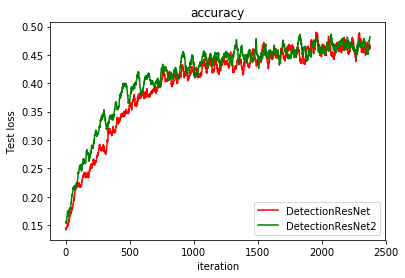

In [27]:
draw_stats([train_ppls[1].get_variable('acc_history'), train_ppls[2].get_variable('acc_history')], model_names[1:], \
           'accuracy','Test loss')

# Larger data

In [28]:
import pandas as pd
from collections import defaultdict

In [32]:
statistics = defaultdict(list)
window = 100
for index in range(3):
    statistics['huber'].append((np.mean(train_ppls[index].get_variable('huber_loss_history')[-window:])))
    statistics['cross entropy'].append(np.mean(train_ppls[index].get_variable('ce_loss_history')[-window:]))
    statistics['accuracy'].append(np.mean(train_ppls[index].get_variable('acc_history')[-window:]))

In [33]:
stats = pd.DataFrame(statistics, index=model_names)
stats

,accuracy,cross entropy,huber
SimpleDetection,0.0000,0.000000,0.015192
DetectionResNet,0.4658,1.292889,0.016349
DetectionResNet2,0.4666,1.228982,0.016102


# Visualizations

In [39]:
saved_feed_dict={'images': B('images'),
                 'labels': B('labels'),
                 'coordinates': B('coordinates'),
                 'other_coordinates': B('other_coordinates'),
                 'other_labels':  B('other_labels')}

saved_fetches=[V('loss_history'),
               V('acc_history'),
               V('ce_loss_history'),
               V('huber_loss_history'),
               V('predicted_labels'),
               V('predicted_boxes'),
#                V('all_accuracies'),
               V('true_coordinates')
              ]

template_predict_ppl = ((template_ppl)
                          .init_variable('predicted_labels', init_on_each_run=list)
                          .init_variable('predicted_boxes', init_on_each_run=list)
                          .init_variable('all_accuracies', init_on_each_run=list)
                          .init_variable('true_coordinates', init_on_each_run=list))


In [40]:
predict_ppls = []

In [41]:
for index, name in enumerate(model_names):
    fetches_list=['loss',
                  name + '/accuracy',
                  name + '/ce_loss:0',
                  name + '/huber:0',
                  name + '/labels_hat:0',
                  name + '/predicted_bb:0',
#                   name + '/all_acuracies:0',
                  name + '/true_normalized:0']

    ppl_predict = ((template_ppl << mnistset.test)
                     .import_model(name, train_ppls[index])
                     .predict_model(name, fetches=fetches_list, feed_dict=saved_feed_dict,
                                  save_to=saved_fetches, mode='a'))
    predict_ppls.append(ppl_predict)

In [42]:
predict_ppls

In [43]:
# batch = ppl_predict.next_batch(100, n_epochs=None, shuffle=True)
# images = batch.data.images
# coordinates = batch.data.coordinates
# labels = batch.data.labels

In [44]:
def modify_bb(size, bbox):
    img_width = size[1]
    img_height = size[2]
#     x, y, x_1, y_1 = bbox
    y, x, y_1, x_1 = bbox
    x = min(x, x_1)
    y = min(y, y_1)
    new_x = x * img_width
    new_y = y * img_height
    new_x_1 = x_1 * img_width
    new_y_1 = y_1 * img_height
    bb_width = new_x_1 - new_x
    bb_height = new_y_1 - new_y
    return new_x, new_y, bb_width, bb_height

In [45]:
def plot_image(ppl_predict_f, name):
    fig, ax = plt.subplots(1, 3, figsize=(10,20))
    print('MODEL: ', name)
    for i in range(3):
        batch = ppl_predict_f.next_batch(50, n_epochs=None, shuffle=True)
        images = batch.data.images
        labels = batch.data.labels

        ax[i].imshow(images[-1, :, :, 0])
        new_x, new_y, bb_width, bb_height = modify_bb(images.shape, ppl_predict_f.get_variable('predicted_boxes')[-1][-1])
        print('predicted_coordinates ', ppl_predict_f.get_variable('predicted_boxes')[-1][-1])
    #     print(new_x, new_y, bb_width, bb_height)
    #     print('true_coordinates_norm ', ppl_predict_f.get_variable('true_coordinates')[-1][-1])
        print('true_coordinates ', batch.data.coordinates[-1])
        x, y, width, height = modify_bb(images.shape, ppl_predict_f.get_variable('true_coordinates')[-1][-1])

        rect = patches.Rectangle((x, y), width, height, linewidth=3, edgecolor='g', facecolor='none')
        ax[i].add_patch(rect)
        rect = patches.Rectangle((new_x, new_y), bb_width, bb_height, linewidth=3, edgecolor='r', facecolor='none')
        ax[i].add_patch(rect)
        ax[i].title.set_text('prediction={}, target={}'.format(str(ppl_predict_f.get_variable('predicted_labels')[-1][-1]), \
                                                               str(labels[-1])))
#         plt.title('prediction={}, target={}'.format(str(ppl_predict_f.get_variable('predicted_labels')[-1][-1]), str(labels[-1])))
    #     print('predicted_labels ', ppl_predict_f.get_variable('predicted_labels'))
    #     print('all_accuracies ', ppl_predict_f.get_variable('all_accuracies')[-1])
        print('other_labels ', batch.other_labels[-1])
    plt.show()

In [46]:
a = np.zeros((2, 3, 4))
x, y, z = a.shape
x

2

MODEL:  SimpleDetection
predicted_coordinates  [ 0.17341392  0.29857594  0.50750279  0.57895738]
true_coordinates  [16 36 43 57]
other_labels  [3 5 6]
predicted_coordinates  [ 0.1848959   0.30244243  0.5158394   0.57406926]
true_coordinates  [25  3 52 16]
other_labels  [9 3 9]
predicted_coordinates  [ 0.29443577  0.29161221  0.63126987  0.5845595 ]
true_coordinates  [41 33 68 50]
other_labels  [0 1 3]


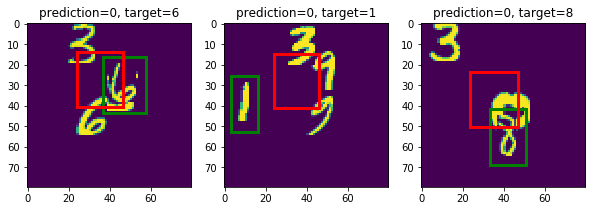

MODEL:  DetectionResNet
predicted_coordinates  [ 0.33928126  0.2578755   0.66315031  0.5466063 ]
true_coordinates  [46 26 73 53]
other_labels  [3 9 4]
predicted_coordinates  [ 0.24203187  0.37840843  0.579413    0.67535138]
true_coordinates  [27 30 54 49]
other_labels  [7 3 4]
predicted_coordinates  [ 0.42874259  0.30444476  0.77069342  0.55352628]
true_coordinates  [28 39 55 52]
other_labels  [9 2 1]


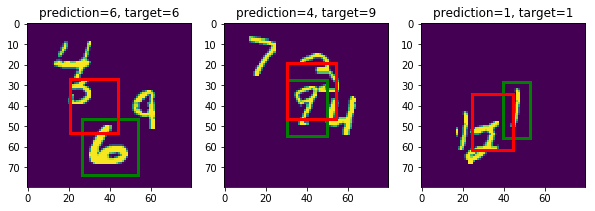

MODEL:  DetectionResNet2
predicted_coordinates  [ 0.36397499  0.30788064  0.70518386  0.62703305]
true_coordinates  [23 36 50 63]
other_labels  [2 1 4]
predicted_coordinates  [ 0.18251596  0.37681288  0.52620643  0.68590182]
true_coordinates  [24 44 51 67]
other_labels  [4 6 4]
predicted_coordinates  [ 0.26174045  0.29786015  0.59619999  0.57682049]
true_coordinates  [27 36 54 58]
other_labels  [8 5 6]


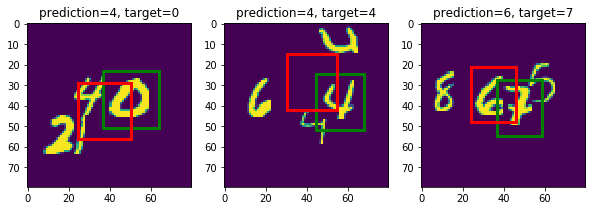

In [142]:
for index in range(3):
    plot_image(predict_ppls[index], model_names[index])

In [90]:
def modify_bb_iou(width, height, bb):
    x, y, x_1, y_1 = bb
    x, x_1 = width * x, width * x_1
    y, y_1 = height * y, height * y_1
    bbox = {'x1': x, 'y2': y_1, 'x2': x_1, 'y1': y}
    return bbox

In [116]:
len(ppl_predict_f.get_variable('predicted_boxes'))

62

In [149]:
for index in range(3):
    ppl_predict_f = predict_ppls[index]
    BATCH_SIZE = 50
    batch = ppl_predict_f.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
    images = batch.data.images
    width = images.shape[1]
    height = images.shape[2]
    ious = []
    for i in range(BATCH_SIZE):
        all_ious = []
        for j in range(len(batch.data.other_coordinates[i])):
            bbox = batch.data.other_coordinates[i][j]
            all_ious.append(get_iou(modify_bb_iou(width, height, ppl_predict_f.get_variable('predicted_boxes')[-1][i]),\
                            {'x1': bbox[0], 'y2': bbox[3], 'x2': bbox[2], 'y1': bbox[1]}))
        all_ious.append(get_iou(modify_bb_iou(width, height, ppl_predict_f.get_variable('predicted_boxes')[-1][i]),\
                      modify_bb_iou(width, height, ppl_predict_f.get_variable('true_coordinates')[-1][i])))
        ious.append(np.max(np.array(all_ious)))

#         print(ppl_predict_f.get_variable('predicted_boxes')[-1][-1])
#         print(ppl_predict_f.get_variable('true_coordinates')[-1][-1])
    # 1    plot_image(predict_ppls[index], model_names[index])
    print(np.mean(np.array(ious)))

0.286381117481
0.31933174608
0.350033901017


In [107]:
batch.data.other_coordinates

array([[[50, 47, 69, 63],
        [51,  8, 66, 27],
        [31, 23, 50, 28]],

       [[48, 43, 67, 58],
        [19, 13, 38, 28],
        [ 6,  5, 21, 24]],

       [[11, 47, 30, 59],
        [ 5, 37, 24, 54],
        [16, 16, 35, 32]],

       [[36, 42, 55, 54],
        [48, 17, 67, 31],
        [26, 24, 45, 41]],

       [[48, 48, 67, 65],
        [21, 50, 40, 67],
        [32, 50, 51, 64]],

       [[41, 31, 60, 48],
        [41, 44, 60, 48],
        [28,  4, 47, 15]],

       [[ 5, 38, 24, 55],
        [39, 34, 58, 46],
        [45,  3, 64, 14]],

       [[10, 21, 29, 34],
        [44, 25, 63, 37],
        [44, 19, 63, 32]],

       [[17, 49, 36, 65],
        [44, 33, 63, 51],
        [37, 29, 52, 48]],

       [[21, 48, 39, 67],
        [43,  9, 61, 28],
        [51, 39, 70, 58]],

       [[23, 17, 42, 32],
        [ 2, 31, 21, 45],
        [51,  7, 70, 26]],

       [[32,  8, 51, 19],
        [16, 51, 35, 68],
        [31, 17, 50, 26]],

       [[ 4, 44, 23, 63],
        [28, 1

In [61]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou
